The aim is to train a neural network that will predict the price of the house. This is a type of regression problem unlike previous problems that I have covered so far, which were classification problems. In regression problems, the model has to predict the continous value instead of a discrete label. For training the neural network, Boston Housing price dataset is used. This dataset consists of only 506 data points divided into 404 train and 102 test samples. The features used are area, property tax, crime rate, et cetera. The prices are in thousands of USD.

This dataset is provided with the keras so, you can directly use it without downloading it separately.

In [9]:
# import the dataset
from keras.datasets import boston_housing

# load the data using load_data()
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

The data is encoded as Numpy arrays. Let's look at the shape and length of these arrays.

In [10]:
print('The shape of the training data: ', train_data.shape)
print('The shape of the training targets: ', train_targets.shape)
print('The shape of the testing data: ', test_data.shape)
print('The shape of the testing targets: ', test_targets.shape)
print('The length of the training data: ', len(train_data))
print('The length of the training targets: ', len(train_targets))
print('The length of the testing data: ', len(test_data))
print('The length of the testing targets: ', len(test_targets))

The shape of the training data:  (404, 13)
The shape of the training targets:  (404,)
The shape of the testing data:  (102, 13)
The shape of the testing targets:  (102,)
The length of the training data:  404
The length of the training targets:  404
The length of the testing data:  102
The length of the testing targets:  102


It can be seen that the shape of train_data is (404, 13) and the shape of test_data is (102,13). It means that there are 13 features like house tax, area, et cetera. Now, let's look at the contents of the label.

In [11]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [12]:
train_targets[0]

15.2

For first data point, it can be seen that there are 13 different features and corresponding to it is the price of the house in thousands of USD. In this case, it is 15.2 thousand USD.

It can also be seen that the data in different column is in different range. So, let's perform feature normalization i.e., to make mean of each column as 0 and standard deviation as 1. This can be done in the following way:

In [13]:
mean = train_data.mean(axis=0) # axis 0 means column wise
train_data = train_data - mean
std = train_data.std(axis=0)
train_data = train_data/std
test_data = test_data - mean
test_data = test_data/std

Note that the mean and standard deviation of training set is used for test set also. **Never** use any quantity computed on test set.
Now let's first build our neural network (or the model) for this prediction task. Then the above data will be fed to the model and lastly, the model will be tested on the test data to see if the model is correctly trained.

In [14]:
# import models and layers to define the model
from keras import models
from keras import layers

# sequential network is used
model = models.Sequential()

# add 3 layers
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) # input_shape=(13,)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

``` model = models.Sequential() ``` means that the model used is Sequential. Other types of models are also there. We will look into them in other tutorials.

``` model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) ``` means that the first layer that we have added is of type Dense and it contains 64 units. They are Densely connected (also known as fully connected layers). The activation function used is relu (Rectilinear unit). The shape of the input to this layer is of the form (train_data.shape[1],).

``` model.add(layers.Dense(64, activation='relu')) ``` means that the next layer that we have added is of type Dense and it contains 64 units. We are not required to add input_shape argument from second layer onwards, keras will understand the input_shape itself from the first layer's architecture.

```model.add(layers.Dense(1)) ``` this is the final layer. No activation function is used (a linear layer). Applying an activation function would constrain the range the output can take. Now, this model is free to learn output in any range.

``` loss='mse' ``` 'mse' stands for [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error).

``` metrics=['mae'] ``` 'mae' stands for [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error).


Since, number of samples are very less for training, it would be difficult to take out the validation set from it. Let's apply K-fold validation to it.

In [15]:
import numpy as np

k = 4 # k = number of folds
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                          train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                             train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) # input_shape=(13,)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Now, mean of mae of each epoch of each fold can be calculated as follows:

In [18]:
# output of this ==> [mean_at_epoch_1, mean_at_epoch2, ...]
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Now, validation plot can easily be plotted.

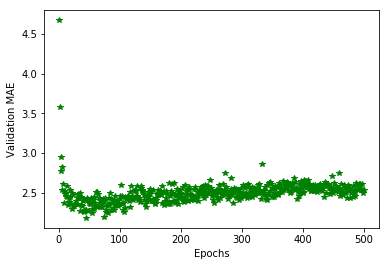

In [25]:
import matplotlib.pyplot as plt

# following line contains a 'magic function' to plot figures on jupyter notebooks
%matplotlib inline 

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'g*')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It can be seen from the above plot that the MAE has stopped improving after 80 epochs. So, let's run the model again with 80 epochs and train it on entire data.

In [27]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) # input_shape=(13,)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 1ms/step


2.582964813008028

This error means that the model still on an average gives price predictions which are off by 2.5829648 * USD 1000 = USD 2582